In [1]:
import numpy as np
import pandas as pd
import pickle, json
import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from skorch import NeuralNetClassifier

import transforms as t
import classifiers as clsf

import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f'Number of cores to use: ', n_cores)

np.random.seed(69)

Number of cores to use:  4


# Data Preprocessing

In [2]:
train_df0 = pd.read_csv('train.csv')
# Y0 are new labels (maybe smoothed or with regression), Y_c0 are original class labels
X0_df, Y_c0, Y0 = t.transform_df(train_df0, train=True, as_df=True, k=None)
X0 = X0_df.values.astype(np.float32)
Y_c0, Y0 = Y_c0.astype(np.int64), Y0.astype(np.int64)
(N, D) = X0.shape

In [3]:
group_inds = t.get_group_inds(X0_df) # This will normalize all prices together, and all vols
#group_inds = [] # This will normalize each feature separately
def get_pars(X):
    return t.get_pars_for_processing(X, group_inds)

# Model Selection

### Grid Search

In [4]:
### Just gonna take a random 10th for validation
X, valX, Y, valY = train_test_split(X0, Y0, shuffle=True, test_size=0.1)
pars = get_pars(X)
X, valX = t.process_with_pars(X, pars), t.process_with_pars(valX, pars)

frac = 1 / 100
t_size, v_size = int(X.shape[0] * frac), int(valX.shape[0] * frac)
train_res, test_res, models = clsf.TuneClassifiers(X[:t_size], valX[:v_size], Y[:t_size], valY[:v_size], \
                                                   algs=['NN', 'RF', 'GDB', 'ADB'], nFeat=D)
test_res

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6787       0.6514        0.6462  0.0717
      2        0.6492       0.6504        0.6450  0.0750
      3        0.6448       0.6485        0.6415  0.0780
Tuning ADB ...
Tuned in: 5.582156181335449
{'learning_rate': 0.2, 'n_estimators': 50}
Tuning RF ...
Tuned in: 6.695171117782593
{'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 50}
Tuning GDB ...
Tuned in: 3.4802229404449463
{'learning_rate': 0.1, 'n_estimators': 50}
Tuning NN ...
Re-initializing module because the following parameters were re-set: drop, hidden, nFeat.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: drop, hidden, nFeat.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7194       0.5661        0.6887  0.0705
      2     

,Classifier,Type,Tuning,Accuracy,AUC
1,ADB,test,base,0.650338,0.639414
3,RF,test,base,0.636824,0.609837
5,GDB,test,base,0.638514,0.616423
7,NN,test,base,0.625000,0.536620
9,ADB,test,tuned,0.640203,0.630278
11,RF,test,tuned,0.623311,0.618615
13,GDB,test,tuned,0.635135,0.623064
15,NN,test,tuned,0.601351,0.501120


### Save grid search results

In [5]:
cv_res_dict = {}
for name, model in models.items():
    info_dict = model.cv_results_
    s = list(zip(info_dict['params'],\
                 info_dict['mean_test_score'],\
                 info_dict['std_test_score']))
    s = sorted(s, key=lambda x: x[1], reverse=True) # Sort by mean test_score
    cv_res_dict[name] = s

gName = 'grid_search.json'
with open(gName, 'w') as f:
    json.dump(cv_res_dict, f, indent=4, sort_keys=True)

### Cross Validation

In [15]:
#clf = RandomForestClassifier(max_features=0.5, n_estimators=1000, min_samples_leaf=75)
clf = RandomForestClassifier(**models['RF'].best_params_)
#clf = AdaBoostClassifier(**models['ADB'].best_params_)
#clf = GradientBoostingClassifier(**models['GDB'].best_params_)
#clf = NeuralNetClassifier(clsf.NNModel, **models['NN'].best_params_,\
#                          iterator_train__shuffle=True, module__nFeat=D)
aucs, accs = clsf.cross_val(clf, X0, Y0, (get_pars, t.process_with_pars))
#aucs.mean(), accs.mean()

CV fold: 3it [02:01, 40.62s/it]


# Final Fitting

In [7]:
# Maybe parallelize
if 'n_jobs' in clf.get_params():
    clf.set_params(n_jobs=n_cores)

pars = get_pars(X0)
process = lambda x: t.process_with_pars(x, pars).astype(np.float32)
X = process(X0)
clf.fit(X, Y0);

### Save Model

In [8]:
fName = datetime.today().strftime('%y%m%d_%H%M') + "_model.pkl"

with open(fName, 'wb') as f:
    pickle.dump(clf, f)
    
with open(fName, 'rb') as f:
    clf = pickle.load(f)

### Feature Importances

In [9]:
imp_dict = {}
if hasattr(clf, 'feature_importances_'):
    inds = np.array(sorted(range(len(X0_df.columns)), \
                           key=lambda x: clf.feature_importances_[x], \
                           reverse=True))
    imp_dict = dict(zip(X0_df.columns[inds], clf.feature_importances_[inds]))
imp_dict

{'ask1vol': 0.17649696529924358,
 'bid1vol': 0.07116002447660612,
 'id': 0.0697959490356504,
 'bid5vol': 0.036525107822504836,
 'ask5vol': 0.03592769473060931,
 'bid4vol': 0.03552304563789353,
 'bid2vol': 0.03499491715770708,
 'ask2vol': 0.03490456669866702,
 'bid3vol': 0.034387858392109234,
 'ask4vol': 0.03432820914238,
 'ask3vol': 0.03411281636543517,
 'mid': 0.033795849277751006,
 'last_price': 0.031522942919964596,
 'bid5': 0.027645266765396196,
 'ask5': 0.027547191439308994,
 'ask4': 0.02727609219967185,
 'bid1': 0.02726081084907805,
 'bid3': 0.026939326181381104,
 'ask1': 0.026923708728545093,
 'bid4': 0.026601277326857572,
 'ask3': 0.026497795542240712,
 'ask2': 0.026121658032487588,
 'bid2': 0.026112839768608394,
 'transacted_qty': 0.022042135712414687,
 'closed_position_qty': 0.01673938083343613,
 'd_open_interest': 0.01461878092697529,
 'opened_position_qty ': 0.014197788737076404}

### Final train performance (on original labels)

In [10]:
auc(Y_c0, clf.predict_proba(X)[:,1]) # Get auc on original labels

0.824646173034451

In [11]:
(clf.predict(X) == Y0).mean()

0.7369948343968399

# Get Predictions on Test Set

In [12]:
test_df0 = pd.read_csv('test.csv')
tX = t.transform_df(test_df0)
tX = process(tX)

output = clf.predict_proba(tX)[:, 1]
     
output_df = pd.DataFrame({'id':test_df0['id'], 'Predicted': output})
output_df.to_csv(f"submission_{datetime.today().strftime('%y%m%d_%H%M')}.csv", index=False)

### Sanity checks on output

mean of train_labels: 0.3569583713157095
mean of train_preds: 0.38419169229293704


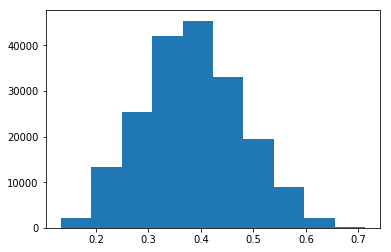

In [13]:
assert(np.all((0 <= output) & (output <= 1)))
print(f'mean of train_labels: {np.mean(Y_c0)}')
print(f'mean of train_preds: {np.mean(output)}')
plt.hist(output);

# random code scraps

In [14]:
raise ValueError('Garbage Beyond!')

ValueError: Garbage Beyond!

In [ ]:
parFName = 'best_pars.pars'
with open(parFName, 'rb') as f:
    best_pars = pickle.load(f)
    
best_pars

In [ ]:
pars = get_pars(X0)
process = lambda x: t.process_with_pars(x, pars)
reps = 4

for clf in tqdm.tqdm_notebook([RandomForestClassifier(max_features=0.3, min_samples_leaf=100, n_estimators=150),
            RandomForestClassifier(max_features=0.4, min_samples_leaf=80, n_estimators=150),
            RandomForestClassifier(max_features=0.5, min_samples_leaf=50, n_estimators=150)] * reps):
    # Maybe parallelize
    if 'n_jobs' in clf.get_params():
        clf.set_params(n_jobs=n_cores)
    X = process(X0)
    clf.fit(X, Y0)
    fName = datetime.today().strftime('%y%m%d_%H%M') + "_model.pkl"
    with open(fName, 'wb') as f:
        pickle.dump(clf, f)